In [ ]:
sdtimport pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2021_altın_mudahale/preprocessed_twitter_2021_altın_mudahale.csv')

In [ ]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,", finnish industrial workers threaten strike w...",0.000000,0.000000,Neutral
1,1,happened btc$ eoy 🤷‍♂️ reminds fools gold crypto,0.000000,0.000000,Neutral
2,2,plop supercooled ice 💦 copper gold swimmingspo...,0.400000,-0.150000,Negative
3,3,jp morgan turns bearish anything-- especially ...,1.000000,0.000000,Neutral
4,4,year clean energy finally faced mining problem...,0.679451,0.157656,Positive


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     4988
Positive    3068
Negative     872
Name: Analysis, dtype: int64
Total comments:  8928


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :46


In [ ]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[1416, 3249, 835, 841]]


In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [ ]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [ ]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

3925     Neutral
6488     Neutral
1656    Positive
842      Neutral
8159     Neutral
2104    Negative
509     Positive
8412     Neutral
5711    Positive
3435     Neutral
Name: Analysis, dtype: object
Text to number
[1 1 2 1 1 0 2 1 2 1]
Number to category
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
x_test.shape

(893, 256)

In [ ]:
test_labels.shape

(893, 3)

In [ ]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
252/252 [==============================] - 229s 877ms/step - loss: 1.1901 - categorical_accuracy: 0.7836 - auc: 0.9090 - val_loss: 0.5776 - val_categorical_accuracy: 0.8981 - val_auc: 0.9893
Epoch 2/10
252/252 [==============================] - 218s 864ms/step - loss: 0.5642 - categorical_accuracy: 0.9236 - auc: 0.9855 - val_loss: 0.3503 - val_categorical_accuracy: 0.9787 - val_auc: 0.9982
Epoch 3/10
252/252 [==============================] - 212s 840ms/step - loss: 0.4439 - categorical_accuracy: 0.9566 - auc: 0.9919 - val_loss: 0.3026 - val_categorical_accuracy: 0.9843 - val_auc: 0.9983
Epoch 4/10
252/252 [==============================] - 211s 837ms/step - loss: 1.1252 - categorical_accuracy: 0.8915 - auc: 0.9689 - val_loss: 0.4572 - val_categorical_accuracy: 0.9474 - val_auc: 0.9943
Epoch 5/10
252/252 [==============================] - 210s 835ms/step - loss: 0.4626 - categorical_accuracy: 0.9355 - auc: 0.9885 - val_loss: 0.3366 - val_categorical_accuracy: 0.9787 - val_au

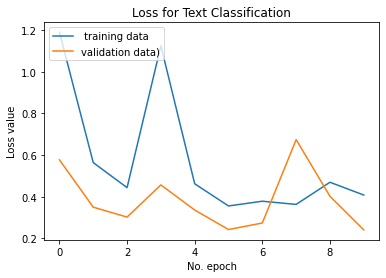

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

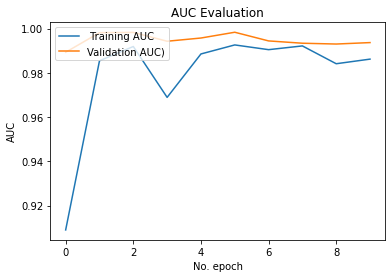

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
X_test

7624    reasons invest gold 👉 goldira gold smartinvest...
994     expensive you, disagree ;scan barcode. hint: o...
7577    live goldprice spot gold trading $. usd, lower...
6967    live goldprice spot gold trading $. usd, highe...
6632    gold nosedives , tola domestic bullion - metti...
                              ...                        
3994    card payment systems gwynedd | contactless por...
2076    trading signal brent : oil giving days rise. l...
1644    question? influenced? influences buy? buy want...
8009                                     الذهب xauusd adx
4860                                                cheap
Name: tweet, Length: 893, dtype: object

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-22-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
28/28 [==============================] - 2s 71ms/step


array([1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2,
       1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1, 1,
       2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2,

In [ ]:
y_test.shape
y_test

7624     Neutral
994     Negative
7577    Positive
6967    Positive
6632     Neutral
          ...   
3994     Neutral
2076    Positive
1644    Positive
8009     Neutral
4860    Positive
Name: Analysis, Length: 893, dtype: object

In [ ]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [ ]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       0.98      0.99      0.99       309
    Negative       0.99      0.86      0.92        87
     Neutral       0.98      1.00      0.99       497

    accuracy                           0.98       893
   macro avg       0.98      0.95      0.97       893
weighted avg       0.98      0.98      0.98       893

